檔案 '/kaggle/working/model_MLHW3.h5' 已成功刪除。
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.3767 - loss: 0.9783 - val_accuracy: 0.8267 - val_loss: 0.7428
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.8316 - loss: 0.7276 - val_accuracy: 0.9533 - val_loss: 0.5971
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.8856 - loss: 0.5759 - val_accuracy: 0.9933 - val_loss: 0.4952
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9230 - loss: 0.5407 - val_accuracy: 1.0000 - val_loss: 0.4410
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9479 - loss: 0.4252 - val_accuracy: 1.0000 - val_loss: 0.0769
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9312 - loss: 0.2020 - val_accuracy: 1.0000 - val_loss: 0.0525
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9463 - loss: 0.1752 - val_accuracy: 1.0000 - val_loss: 0.0514
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accurac

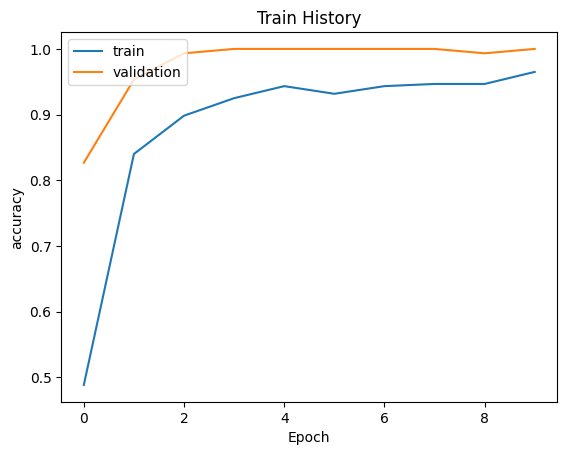

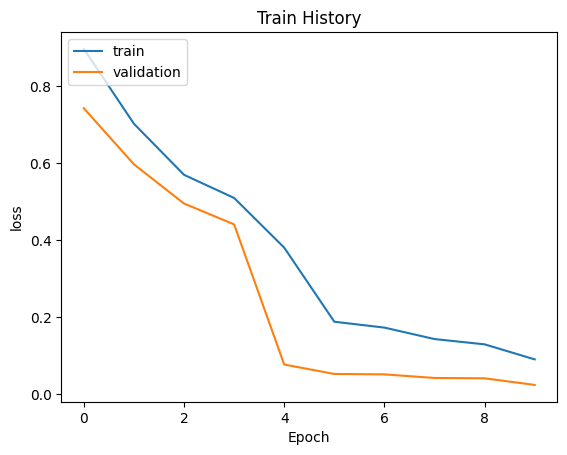

In [6]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt  
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import warnings

def plot_image(image):  
    fig = plt.gcf()  
    fig.set_size_inches(2,2)  
    plt.imshow(image, cmap='binary')  
    plt.show()  

def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)  
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx], cmap='binary')  
        title = "l=" + str(labels[idx])  
        if len(prediction) > 0:  
            title = "l={},p={}".format(str(labels[idx]), str(prediction[idx]))  
        else:  
            title = "l={}".format(str(labels[idx]))  
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1  
    plt.show()  

def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show() 
    
# 忽略警告
warnings.simplefilter("ignore")

model_path = '/kaggle/working/model_MLHW3.h5'
if os.path.exists(model_path):
    os.remove(model_path)
    print(f"檔案 '{model_path}' 已成功刪除。")
else:
    print(f"檔案 '{model_path}' 不存在，無需刪除。")

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# 讀取訓練資料
train_inner_break = np.load('/kaggle/input/ml-hw3/train_inner_break.npy')
train_normal = np.load('/kaggle/input/ml-hw3/train_normal.npy')
train_outer_break = np.load('/kaggle/input/ml-hw3/train_outer_break.npy')

# 標籤設定
X_train = np.concatenate((train_inner_break, train_normal, train_outer_break))
y_train = np.concatenate((np.ones(train_inner_break.shape[0]), np.zeros(train_normal.shape[0]), np.full(train_outer_break.shape[0], 2)))

# 轉換為模型所需的格式
X_train = np.expand_dims(X_train, axis=2)

# 分割訓練集和驗證集
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 建立CNN模型
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 這裡的3代表3個類別
])

#model.summary()

# 編譯模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 訓練模型
train_history = model.fit(x_train, y_train, validation_data=(np.array(x_val), np.array(y_val)),epochs=10, batch_size=32,callbacks=[early_stopping])

# 保存模型
model.save(model_path)

print('模型訓練完成')

show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [7]:
# 讀取測試資料
X_test = np.load('/kaggle/input/ml-hw3/test.npy')

# 轉換為模型所需的格式
X_test = np.expand_dims(X_test, axis=2)

# 進行預測
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# 轉換預測結果為標籤
label_map = {0: 'normal', 1: 'inner_break', 2: 'outer_break'}
predicted_labels = [label_map[prediction] for prediction in predicted_labels]

# 創建DataFrame並保存到CSV
results_df = pd.DataFrame(predicted_labels)
results_df.to_csv('/kaggle/working/HW3.csv', index=False, header=False)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
